In [49]:
import pandas as pd
import numpy as np
import httpx
from datetime import datetime
import matplotlib.pyplot as plt

# Функции

## Функция для получения данных

In [39]:
async def fetch_bybit_data(url, params):
    async with httpx.AsyncClient() as client:
        try:
            response = await client.get(url, params=params, timeout=10.0)
            response.raise_for_status()
            result = response.json()
            return result["result"]

        except httpx.RequestError as e:
            return {"error": f"Request failed: {str(e)}"}
        except httpx.HTTPStatusError as e:
            return {"error": f"HTTP error: {str(e)}"}

## Функция для получения данных по свечам

In [40]:
async def get_kline(url,  symbol = "BTCUSDT", interval = "1", limit = 25):
    params = {
        "category": "spot",
        "symbol": symbol,
        "interval": interval,
        "limit": limit,
    }
    data = await fetch_bybit_data(url, params)

    return data

## Функция для приведения данных о свечах к единному формату

In [41]:
def format_kline_data(data):
    formatted_list = []
    list = data["list"]

    for elem in list:
        formatted_list.append(
            {
                "time": datetime.fromtimestamp(int(elem[0]) / 1000).strftime(
                    "%d-%m-%Y %H:%M:%S"
                ),
                "open": float(elem[1]),
                "high": float(elem[2]),
                "low": float(elem[3]),
                "close": float(elem[4]),
                "volume": float(elem[5]),
                "turnover": float(elem[6]),
            }
        )

    return formatted_list

## Функция для формирования датафрейма

In [42]:
def make_dataframe(data):
    dataframes = []

    for elem in data:
        elem["open"] = float(elem["open"])
        elem["close"] = float(elem["close"])
        elem["high"] = float(elem["high"])
        elem["low"] = float(elem["low"])
        elem["volume"] = float(elem["volume"])
        dataframes.append(pd.DataFrame(elem, index=[0]))

    initial_df = pd.concat(dataframes, ignore_index=True)

    df = initial_df.iloc[::-1].reset_index(drop=True)

    return df

## Функция для расчета осцилятора Чайкина

In [43]:
def chaikin_osc(df):
        # 1. Рассчитать Money Flow Multiplier
    df["mf_multiplier"] = ((df["close"] - df["low"]) - (df["high"] - df["close"])) / (df["high"] - df["low"])

    # 2. Рассчитать Money Flow Volume
    df["mf_volume"] = df["mf_multiplier"] * df["volume"]

    # 3. Рассчитать ADL
    df["adl"] = df["mf_volume"].cumsum()

    # 4. Рассчитать EMA для short и long периодов
    short_period = 3
    long_period = 10

    df["ema_short"] = df["adl"].ewm(span=short_period, adjust=False).mean()
    df["ema_long"] = df["adl"].ewm(span=long_period, adjust=False).mean()

    # 5. Рассчитать Chaikin Oscillator
    df["chaikin_osc"] = df["ema_short"] - df["ema_long"]

    return df

## Функция для расчета RSI

In [44]:
def rsi(df, period):
    df["delta"] = df["close"].diff()  # Разница между текущей и предыдущей ценой закрытия

    df["gain"] = df["delta"].where(df["delta"] > 0, 0)  # Приросты (положительные изменения)
    df["loss"] = -df["delta"].where(df["delta"] < 0, 0)  # Потери (отрицательные изменения)

    # Скользящее среднее приростов и потерь
    df["avg_gain"] = df["gain"].rolling(window=period, min_periods=1).mean()
    df["avg_loss"] = df["loss"].rolling(window=period, min_periods=1).mean()

    # Отношение приростов к потерям
    df["rs"] = df["avg_gain"] / df["avg_loss"]
    df["RSI"] = 100 - (100 / (1 + df["rs"]))  # Формула RSI

    return df

# Bybit

## Получаем данные по свечам

In [67]:
url = "https://api.bybit.com/v5/market/kline"

kline_data = await get_kline(url, symbol="BTCUSDT", interval=1, limit=1000)
klines = format_kline_data(kline_data)

klines_df_0 = make_dataframe(klines)

klines_df_1 = chaikin_osc(klines_df_0)

klines_df_2 = rsi(klines_df_1, period=14)

# Настройка отображения
pd.set_option('display.max_columns', None)  # Показывать все столбцы
pd.set_option('display.width', 0)          # Не ограничивать ширину строки
pd.set_option('display.expand_frame_repr', False)


print(klines_df_2[["time", "open", "close", "volume", "chaikin_osc", "RSI"]])

                    time       open      close     volume  chaikin_osc         RSI
0    18-12-2024 21:54:00  104256.05  104204.61  22.826640     0.000000         NaN
1    18-12-2024 21:55:00  104204.61  104248.55  23.869164     6.895044  100.000000
2    18-12-2024 21:56:00  104248.55  104193.52  19.640130     4.372174   44.397292
3    18-12-2024 21:57:00  104193.52  104109.16  19.071280    -1.721783   23.967709
4    18-12-2024 21:58:00  104109.16  104133.14  12.349078    -0.989662   32.762530
..                   ...        ...        ...        ...          ...         ...
995  19-12-2024 14:29:00  101653.63  101623.79  18.009522    -8.616671   31.434866
996  19-12-2024 14:30:00  101623.79  101668.67  14.690571    -4.353550   44.289355
997  19-12-2024 14:31:00  101668.67  101673.90  21.778885    -3.765310   35.416130
998  19-12-2024 14:32:00  101673.90  101797.95  13.970411     1.036270   53.423594
999  19-12-2024 14:33:00  101797.95  101797.89   9.788721     2.240942   57.049953

[10

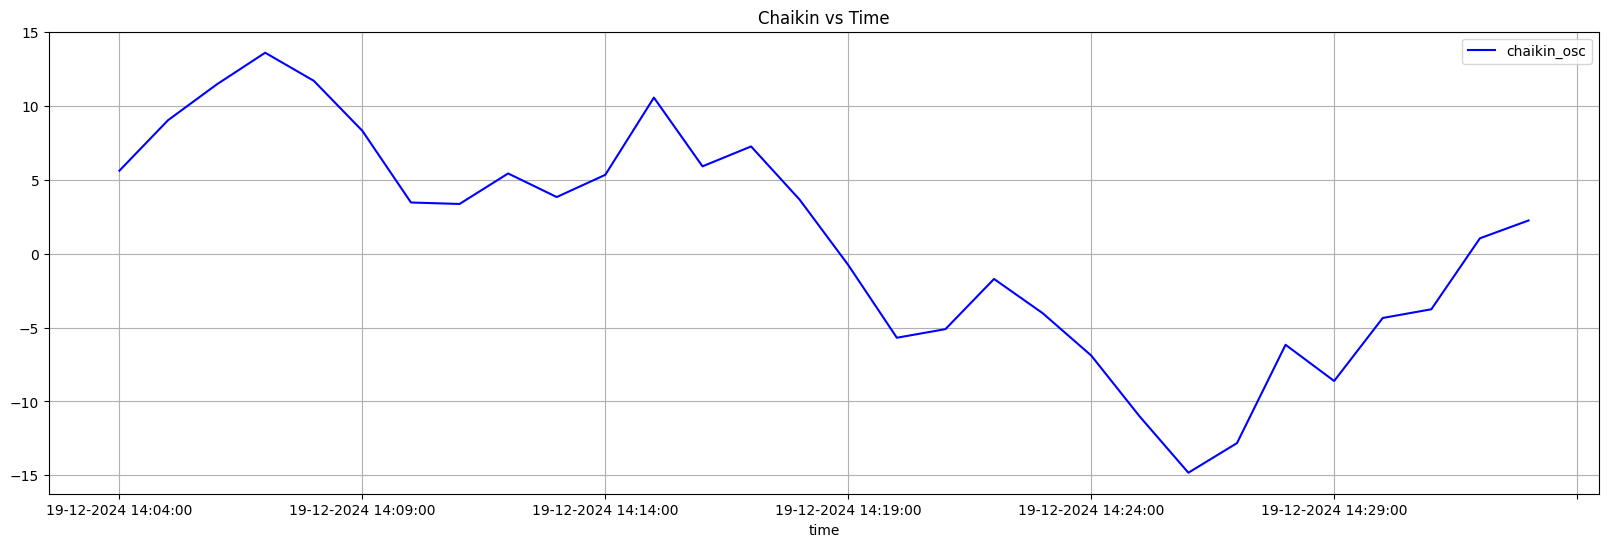

In [68]:
klines_df_2[-30:].plot(
    x='time', 
    y='chaikin_osc', 
    figsize=(20, 6),  # Размер графика
    title='Chaikin vs Time',  # Заголовок
    color='blue',  # Цвет линии
    linewidth=1.5,  # Толщина линии
    grid=True  # Включить сетку
);

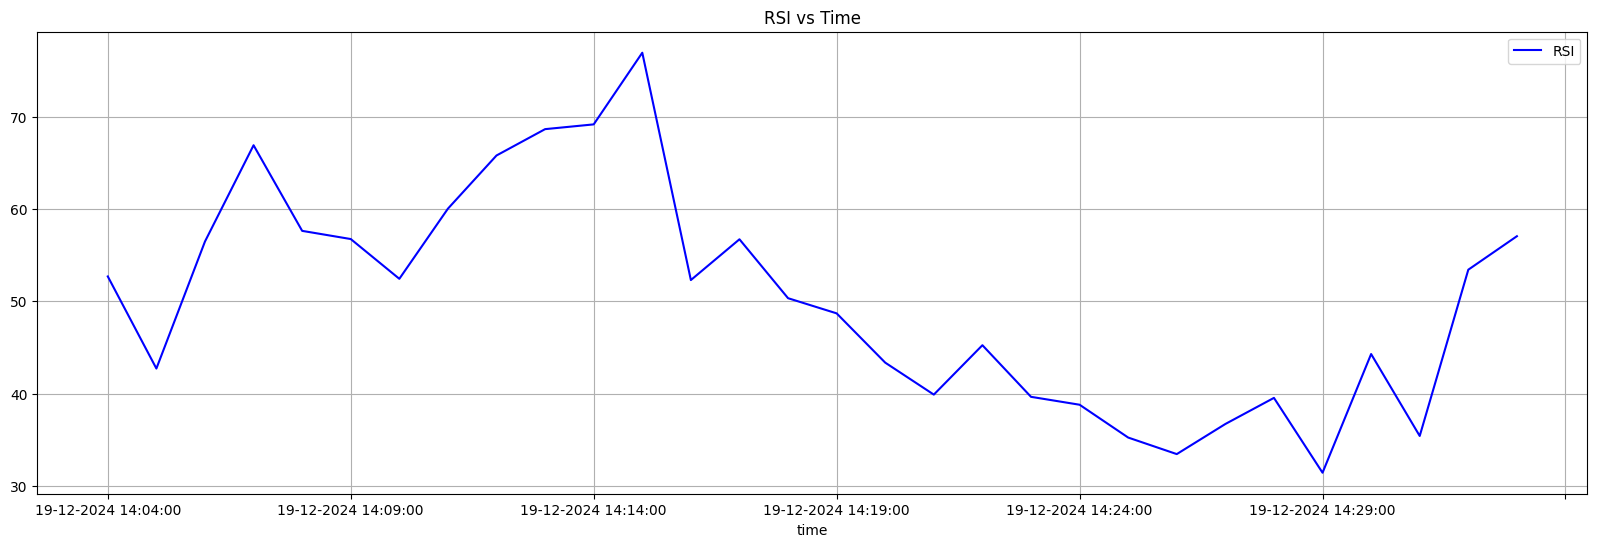

In [69]:
klines_df_2[-30:].plot(
    x='time', 
    y='RSI', 
    figsize=(20, 6),  # Размер графика
    title='RSI vs Time',  # Заголовок
    color='blue',  # Цвет линии
    linewidth=1.5,  # Толщина линии
    grid=True  # Включить сетку
);